In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import glob
import torch.optim as optim
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, stride=1, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

def srcnn_predict(model, im_b):
    im_b_tensor = im_b.clone().detach().unsqueeze(0).unsqueeze(0)
    # im_b_tensor = torch.tensor(im_b, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
    # print(im_b_tensor.shape)

    with torch.no_grad():
        model.eval()
        im_h_tensor = model(im_b_tensor.to(device))

    im_h = im_h_tensor.squeeze(0).squeeze(0).cpu().numpy()
    
    return im_h

def compute_psnr(im1, im2):
    imdff = im1.astype(np.float64) - im2.astype(np.float64)
    imdff = imdff.flatten()

    rmse = np.sqrt(np.mean(imdff ** 2))

    if rmse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(255 / rmse)

    return psnr

In [4]:
class ImageDataset(Dataset):
    img_segments_lr = []
    img_segments_hr = []

    def __init__(self, folder_path, upscale_factor=3, segment_size=(33, 33), stride=14):
        self.image_paths = glob.glob(os.path.join(folder_path, '*.bmp'))
        self.upscale_factor = upscale_factor
        self.segment_size = segment_size
        self.stride = stride
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Grayscale(),
            # transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        self.img_segments_lr = []
        self.img_segments_hr = []

        img = Image.open(self.image_paths[idx]).convert('L')  # Convert to grayscale
        img = self.transform(img)

        img_height, img_width = img.shape[1], img.shape[2]

        for y in range(0, img_height - self.segment_size[0] + self.stride, self.stride):
            for x in range(0, img_width - self.segment_size[1] + self.stride, self.stride):
                hr_segment = img[:, y:y+self.segment_size[0], x:x+self.segment_size[1]]

                lr_segment = nn.functional.interpolate(hr_segment.unsqueeze(0), 
                                                       scale_factor=1/self.upscale_factor, 
                                                       mode='bicubic', 
                                                       align_corners=False)
                lr_segment = nn.functional.interpolate(lr_segment, 
                                                       size=hr_segment.shape[1:], 
                                                       mode='bicubic', 
                                                       align_corners=False)

                self.img_segments_lr.append(lr_segment.squeeze(0))
                self.img_segments_hr.append(hr_segment.squeeze(0))


        return self.img_segments_lr, self.img_segments_hr

In [5]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=50):
    model.train()
    cnt_bpgs = 0
    for epoch in range(num_epochs):
        epoch_loss = 0
        img = 0
        for lr_images, hr_images in dataloader:
            img += 1
            print(img)
            # avg_psnr = 0
            for i in range(len(lr_images)):
                optimizer.zero_grad()
                outputs = model(lr_images[i].to(device))
                loss = criterion(outputs.squeeze(1), hr_images[i].to(device))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                cnt_bpgs += 1
                # if img % 30 == 0:
                    # hr = hr_images[i].squeeze(0).squeeze(0).cpu().numpy()
                    # upsc = outputs.squeeze(0).squeeze(0).cpu().detach().numpy()
                    # avg_psnr += compute_psnr(hr, upsc)
            # if img % 30 == 0:
                # print("PSNR:", avg_psnr / len(lr_images))
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}')
    print("Backprops", cnt_bpgs)

In [6]:
mode = "load"
# mode =  "train"
# mode = "load-train"
batch_size = 1
learning_rate = 1e-4
num_epochs = 20 #1000 ~25.000.000 backprops  24701/epoch
upscale_factor = 3

In [7]:
train_dataset = ImageDataset('./Train', upscale_factor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# model = SRCNN().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.SGD([
#     {'params': model.conv1.parameters(), 'lr': learning_rate},
#     {'params': model.conv2.parameters(), 'lr': learning_rate},
#     {'params': model.conv3.parameters(), 'lr': learning_rate * 0.1}  # Lower learning rate for last layer
# ], momentum=0.9)

# model = SRCNN().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam([
#     {'params': model.conv1.parameters(), 'lr': learning_rate},
#     {'params': model.conv2.parameters(), 'lr': learning_rate},
#     {'params': model.conv3.parameters(), 'lr': learning_rate * 0.1}  # Lower learning rate for last layer
# ])

model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
if mode == "train":
    train_model(model, train_dataloader, criterion, optimizer, num_epochs)
    torch.save(model.state_dict(), 'TrainedModels/'+'load_and_train_test.pt')
elif mode == "load-train":
    model.load_state_dict(torch.load('TrainedModels/'+'load_and_train_test.pt'))
    train_model(model, train_dataloader, criterion, optimizer, num_epochs)
else:
    model.load_state_dict(torch.load('TrainedModels/'+'srcnn_model_50e.pt'))
    print(model)

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


C:\Users\Alexey\AppData\Local\Temp\ipykernel_17736\2599620348.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('TrainedModels/'+'srcnn_mo

### Results

In [10]:
# test_dataset = ImageDataset('./Test/Set5', upscale_factor, segment_size=(33, 33), stride=21)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [11]:
# def prepImage(gt_img, upscale_factor = 3):
#     transform = transforms.Compose([
#             transforms.ToTensor(),
#             # transforms.Grayscale(),
#             # transforms.Normalize((0.5,), (0.5,))
#         ])
    
#     gt_img = transform(gt_img)

#     # print(gt_img.unsqueeze(0).shape)

#     lr_img = nn.functional.interpolate(gt_img.unsqueeze(0), 
#                                             scale_factor=1/upscale_factor, 
#                                             mode='bicubic', 
#                                             align_corners=False)
#     lr_img = nn.functional.interpolate(lr_img, 
#                                             size=gt_img.shape[1:], 
#                                             mode='bicubic', 
#                                             align_corners=False)
#     return gt_img.squeeze(0).squeeze(0).numpy(), lr_img.squeeze(0).squeeze(0)

from skimage.transform import resize

def prepImage(gt_img, upscale_factor=3):
    gt_data = np.array(gt_img)

    # gt_data = np.expand_dims(gt_data, axis=0)
    # gt_data = np.expand_dims(gt_data, axis=0)

    lr_data = resize(gt_data, (gt_data.shape[0] // upscale_factor, gt_data.shape[1] // upscale_factor), order=3)
    lr_data = resize(lr_data, gt_data.shape, order=3)

    transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Grayscale(),
            # transforms.Normalize((0.5,), (0.5,))
        ])
    gt_data = transform(gt_data).squeeze(0)
    lr_data = transform(lr_data).squeeze(0)

    return gt_data.numpy(), lr_data.float()

def showIm(tensor2d):
    plt.imshow(np.clip(tensor2d, 0, 1))
    plt.axis('off')
    plt.show()

def show_three_images(images, labels, figsize=(12, 4)):
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    for i in range(3):
        axes[i].imshow(np.clip(images[i], 0, 1))
        axes[i].set_title(labels[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

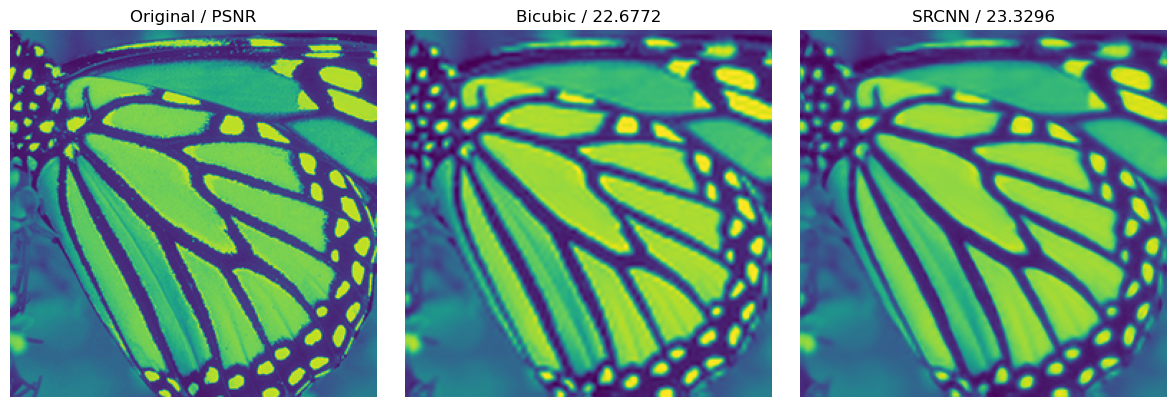

In [12]:
path = "./Test/Set5/butterfly_GT.bmp"
# path = "./Test/Set14/zebra.bmp"
# path = "./Test/Set14/lenna.bmp"
# path = "./Test/test.bmp"
gt_img = Image.open(path).convert('L')
gt_img, lr_img = prepImage(gt_img, upscale_factor=3)
up_img = srcnn_predict(model, lr_img)

lr_img = lr_img.numpy()

gt_pil = tensor_to_image(gt_img)
lr_pil = tensor_to_image(lr_img)
up_pil = tensor_to_image(up_img)

srcnn_psnr = compute_psnr(np.array(gt_pil), np.array(up_pil))
bicubic_psnr = compute_psnr(np.array(gt_pil), np.array(lr_pil))

show_three_images([gt_img, lr_img, up_img], ["Original / PSNR", f"Bicubic / {round(bicubic_psnr, 4)}", f"SRCNN / {round(srcnn_psnr, 4)}"])

In [13]:
def get_avg_psnr(images_path):
    cnt = 0
    avg_srcnn_psnr = 0
    avg_bicubic_psnr = 0
    for filename in os.listdir(images_path):
        file_path = os.path.join(images_path, filename)
        
        if filename.endswith('.bmp'):
            cnt+=1
            gt_img = Image.open(file_path).convert('L')
            gt_img, lr_img = prepImage(gt_img, upscale_factor=3)
            up_img = srcnn_predict(model, lr_img)

            lr_img = lr_img.numpy()

            gt_pil = tensor_to_image(gt_img)
            lr_pil = tensor_to_image(lr_img)
            up_pil = tensor_to_image(up_img)

            avg_srcnn_psnr += compute_psnr(np.array(gt_pil), np.array(up_pil))
            avg_bicubic_psnr += compute_psnr(np.array(gt_pil), np.array(lr_pil))

    return avg_bicubic_psnr/cnt, avg_srcnn_psnr/cnt

In [14]:
path = "./Test/Set5/"

bic, srcnn = get_avg_psnr(path)

print(bic, srcnn)

29.046843982372508 27.033498008606266


In [15]:

# print("LR - UP PSNR: ", compute_psnr(np.array(lr_pil), np.array(up_pil)))

In [16]:
# add_to_dim = 14

# def combine_patches(patches, img_shape, segment_size=(33,33), stride=14):
#     channels, height, width = img_shape
#     combined_image = torch.zeros((channels, height, width), dtype=torch.float32)
#     count_map = torch.zeros((channels, height, width), dtype=torch.float32)

#     # Calculate the positions of each patch and add them to the combined image
#     idx = 0
#     for y in range(0, height - segment_size[0] + add_to_dim, stride):
#         for x in range(0, width - segment_size[1] + add_to_dim, stride):
#             # Get the current patch
#             patch = patches[idx]
#             combined_image[:, y:y+segment_size[0], x:x+segment_size[1]] += patch
#             count_map[:, y:y+segment_size[0], x:x+segment_size[1]] += 1
#             idx += 1

#     # Avoid division by zero by using a small epsilon value
#     count_map[count_map == 0] = 1
#     combined_image /= count_map

#     return combined_image

In [17]:
# def get_image_segments(img, segment_size = (33,33), stride = 14):
#     img_segments = []

#     img = img.unsqueeze(0)

#     img_height, img_width = img.shape[1], img.shape[2]

#     for y in range(0, img_height - segment_size[0] + add_to_dim, stride):
#         for x in range(0, img_width - segment_size[1] + add_to_dim, stride):
#             segment = img[:, y:y+segment_size[0], x:x+segment_size[1]]

#             img_segments.append(segment.squeeze(0))

#     return img_segments

In [18]:
# # path = "./Test/Set5/butterfly_GT.bmp"
# # path = "./Test/Set14/zebra.bmp"
# # path = "./Test/Set14/lenna.bmp"
# # path = "./Test/test.bmp"
# gt_img = Image.open(path).convert('L')
# gt_img, lr_img = prepImage(gt_img, upscale_factor=1)
# segments = get_image_segments(lr_img)
# showIm(combine_patches(segments, np.expand_dims(gt_img, axis=0).shape).squeeze(0))

# # ups_segments = []

# # for segment in segments:
# #     ups_segments.append(srcnn_predict(model, segment))


# # up_img = combine_patches(ups_segments, np.expand_dims(gt_img, axis=0).shape).squeeze(0)
# # showIm(gt_img)
# # showIm(lr_img)
# # showIm(up_img)
# # plt.imshow(gt_img)
# # plt.imshow(img.squeeze(0))


In [19]:
# gt_pil = tensor_to_image(gt_img)
# lr_pil = tensor_to_image(lr_img)
# up_pil = tensor_to_image(up_img)

# print("Bicubic PSNR: ", compute_psnr(np.array(gt_pil), np.array(lr_pil)))
# print("SRCNN PSNR: ", compute_psnr(np.array(gt_pil), np.array(up_pil)))

In [20]:
# full_up_img = srcnn_predict(model, lr_img)

# showIm(up_img)
# showIm(full_up_img)

# full_up_img = tensor_to_image(full_up_img)
# print("SRCNN PSNR: ", compute_psnr(np.array(full_up_img), np.array(up_pil)))